### **Quantium Data Analytics Virtual Experience Program**



##### **Retail Strategy and Analytics - Task 1**

To get started, download the resource csv data files below and begin performing high level data checks such as:

* Creating and interpreting high level summaries of the data
* Finding outliers and removing these (if applicable)
* Checking data formats and correcting (if applicable)

You will also want to derive extra features such as pack size and brand name from the data and define metrics of interest to enable you to draw insights on who spends on chips and what drives spends for each customer segment. Remember our end goal is to form a strategy based on the findings to provide a clear recommendation to Julia the Category Manager so make sure your insights can have a commercial application.

**LIFESTAGE**: Customer attribute that identifies whether a customer has a family or not and what point in life they are at e.g. are their children in pre-school/primary/secondary school.


**PREMIUM_CUSTOMER**: Customer segmentation used to differentiate shoppers by the price point of products they buy and the types of products they buy. It is used to identify whether customers may spend more for quality or brand or whether they will purchase the cheapest options.


In [ ]:
# required library
# Data analysis and wrangling
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
import missingno
import matplotlib.pyplot as plt

# Dates
import datetime
from matplotlib.dates import DateFormatter

# Text analysis
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist as FreqDist
import re

# Statistical analysis
from scipy.stats import ttest_ind

# Remove warnings
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Import Data

In [ ]:
CustomerData = pd.read_csv("/content/QVI_purchase_behaviour.csv")
TransactionData = pd.read_excel("/content/QVI_transaction_data.xlsx")

In [ ]:
#Transaction Data
TransactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [ ]:
# check null value in Transaction Data
TransactionData.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

<Axes: >

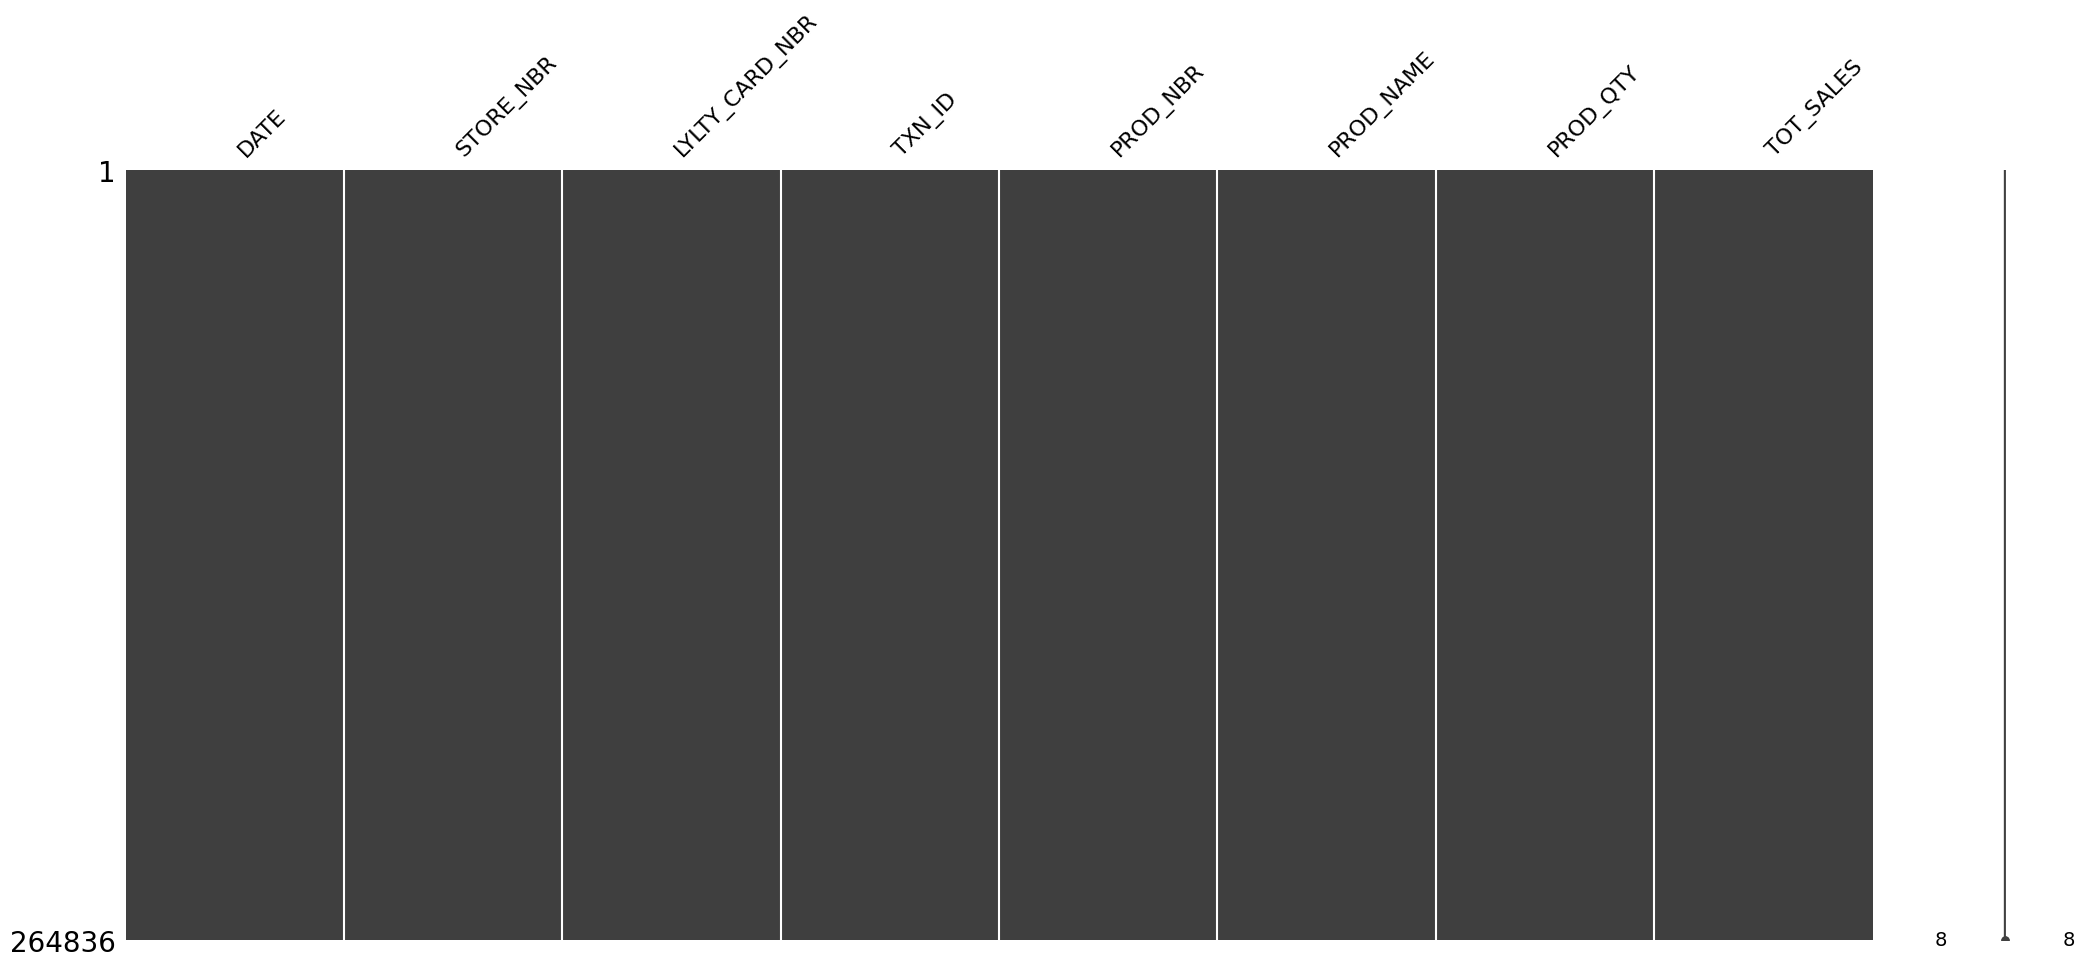

In [ ]:
missingno.matrix(TransactionData)

In [ ]:
# Check Data type for each column in Transaction Data
TransactionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [ ]:
TransactionData['DATE'].head()

0    43390
1    43599
2    43605
3    43329
4    43330
Name: DATE, dtype: int64

In [ ]:
## convert DATE column into Data format (yyyy-mm-dd)
# Function that converts Excel integer into yyyy-mm-dd format
def xlseriesdate_to_datetime(xlserialdate):
    excel_anchor = datetime.datetime(1900, 1, 1)
    if(xlserialdate < 60):
        delta_in_days = datetime.timedelta(days = (xlserialdate - 1))
    else:
        delta_in_days = datetime.timedelta(days = (xlserialdate - 2))
    converted_date = excel_anchor + delta_in_days
    return converted_date

# Apply function to Date feature in transactionData dataset
TransactionData['DATE'] = TransactionData['DATE'].apply(xlseriesdate_to_datetime)

In [ ]:
TransactionData['DATE'].head()

0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: DATE, dtype: datetime64[ns]

In [ ]:
## Examine PROD_NAME
TransactionData['PROD_NAME'].head()

0      Natural Chip        Compny SeaSalt175g
1                    CCs Nacho Cheese    175g
2      Smiths Crinkle Cut  Chips Chicken 170g
3      Smiths Chip Thinly  S/Cream&Onion 175g
4    Kettle Tortilla ChpsHny&Jlpno Chili 150g
Name: PROD_NAME, dtype: object

In [ ]:
## Extract PACK SIZE from PROD_NAME
TransactionData['PACK_SIZE']=TransactionData['PROD_NAME'].str.extract("(\d+)")
TransactionData['PACK_SIZE']=pd.to_numeric(TransactionData['PACK_SIZE'])
TransactionData['PACK_SIZE'].head()

0    175
1    175
2    170
3    175
4    150
Name: PACK_SIZE, dtype: int64

In [ ]:
## Create text cleaning function for PROD_NAME
def clean_text(text):
    text = re.sub('[&/]', ' ', text) # remove special characters '&' and '/'
    text = re.sub('\d\w*', ' ', text) # remove product weights
    return text

# apply function
TransactionData['PROD_NAME']=TransactionData['PROD_NAME'].apply(clean_text)

In [ ]:
TransactionData['PROD_NAME'].head()

0      Natural Chip        Compny SeaSalt 
1                    CCs Nacho Cheese     
2      Smiths Crinkle Cut  Chips Chicken  
3      Smiths Chip Thinly  S Cream Onion  
4    Kettle Tortilla ChpsHny Jlpno Chili  
Name: PROD_NAME, dtype: object

In [ ]:
# Create one giant string and apply 'word_tokenize' to separate the words

cleanProdName = TransactionData['PROD_NAME']
string = ''.join(cleanProdName)
prodWord = word_tokenize(string)

In [ ]:
# Apply 'fdist' function which computes the frequency of each token and put it into a dataframe

wordFrequency = FreqDist(prodWord)
freq_df = pd.DataFrame(list(wordFrequency.items()), columns = ["Word", "Frequency"]).sort_values(by = 'Frequency', ascending = False)

In [ ]:
#### Let's look at the most common words by counting the number of times a word appears and
freq_df


,Word,Frequency
10,Chips,49770
16,Kettle,40739
7,Smiths,28572
6,Cheese,27890
66,Pringles,24743
...,...,...
208,SaltNCC,12
224,SaltSnbts,11
225,SaltFrench,10
222,SaltGrnWves,8


In [ ]:
# There are salsa products in the dataset but we are only interested in the chips category
# remove salsa in prod_name

TransactionData['PROD_NAME']=TransactionData['PROD_NAME'].apply(lambda x: x.lower())
TransactionData=TransactionData[~TransactionData['PROD_NAME'].str.contains("salsa")]
TransactionData['PROD_NAME']=TransactionData['PROD_NAME'].apply(lambda x: x.title())

In [ ]:
TransactionData['PROD_NAME'].head()

0      Natural Chip        Compny Seasalt 
1                    Ccs Nacho Cheese     
2      Smiths Crinkle Cut  Chips Chicken  
3      Smiths Chip Thinly  S Cream Onion  
4    Kettle Tortilla Chpshny Jlpno Chili  
Name: PROD_NAME, dtype: object

In [ ]:
## summarize data to check possible outliers
TransactionData.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PACK_SIZE
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322,175.585178
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828,59.434727
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000,70.000000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000,150.000000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000,170.000000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000,175.000000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000,380.000000


there are no nulls in the collumns, but PROD_QTY appears to have an outlier which we should investigate further. let's see further case where 200 packets of chips are bought in one transaction

In [ ]:
TransactionData.loc[TransactionData['PROD_QTY']==200, :]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380


there are two transaction where 200 packets of chips are bought and both of these transactions by the same customer with card number 226000

In [ ]:
TransactionData.loc[TransactionData['LYLTY_CARD_NBR']==226000,:]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380


its look like this customer has only had two transaction over the year and it is not ordinary retail customer. The customer might be buying chips for commercial purposes instead. So we will remove this loyalty card number for further analysis


In [ ]:
TransactionData.drop(TransactionData.index[TransactionData['LYLTY_CARD_NBR']==226000],inplace=True)
CustomerData.drop(CustomerData.index[CustomerData['LYLTY_CARD_NBR']==226000],inplace=True)

In [ ]:
# make sure it has been dropped

TransactionData.loc[TransactionData['LYLTY_CARD_NBR']==226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE


That's better. Now, let's look at transaction lines over time to see if there is any data issues such as missing data

In [ ]:
TransactionData['DATE']

0        2018-10-17
1        2019-05-14
2        2019-05-20
3        2018-08-17
4        2018-08-18
            ...    
264831   2019-03-09
264832   2018-08-13
264833   2018-11-06
264834   2018-12-27
264835   2018-09-22
Name: DATE, Length: 246740, dtype: datetime64[ns]

In [ ]:
TransactionData.groupby(['DATE']).size()

DATE
2018-07-01    663
2018-07-02    650
2018-07-03    674
2018-07-04    669
2018-07-05    660
             ... 
2019-06-26    657
2019-06-27    669
2019-06-28    673
2019-06-29    703
2019-06-30    704
Length: 364, dtype: int64

There is only 364 rows. Lets's create a sequence of dates from 1 july 2018 to 30 June 2019 to find if there is any missing date

In [ ]:
# Create a new dataframe which contains the total sale for each date

a = pd.pivot_table(TransactionData, values = 'TOT_SALES', index = 'DATE', aggfunc = 'sum')
a.rename(columns={'TOT_SALES':'Total Sales'},inplace=True)

# create new dataframe which total sales 0
b = pd.DataFrame(index = pd.date_range(start = '2018-07-01', end = '2019-06-30'))
b['Total Sales'] = 0

Transaction_byday = a + b
Transaction_byday.fillna(0, inplace = True)
Transaction_byday.index.name='Date'

In [ ]:
Transaction_byday.head()

,Total Sales
Date,
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


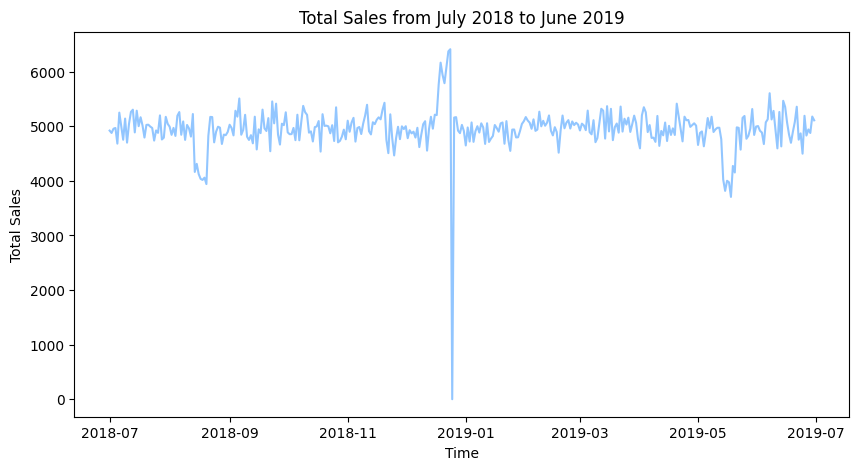

In [ ]:
# Plot Total sales for each date
timeline = Transaction_byday.index
graph = Transaction_byday['Total Sales']

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(timeline, graph)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.title('Total Sales from July 2018 to June 2019')
plt.xlabel('Time')
plt.ylabel('Total Sales')

plt.show()

In [ ]:
# Confirm the date where sales count equals to zero

Transaction_byday[Transaction_byday['Total Sales'] == 0]

,Total Sales
Date,
2018-12-25,0.0


In [ ]:
# Let's look at the December month only

Transaction_desember = Transaction_byday[(Transaction_byday.index<"2019-01-01") & (Transaction_byday.index>"2018-11-30")]
Transaction_desember.head()

,Total Sales
Date,
2018-12-01,5000.9
2018-12-02,4781.1
2018-12-03,4927.0
2018-12-04,4869.4
2018-12-05,4900.5


Text(0.5, 1.0, 'Total Sales in December')

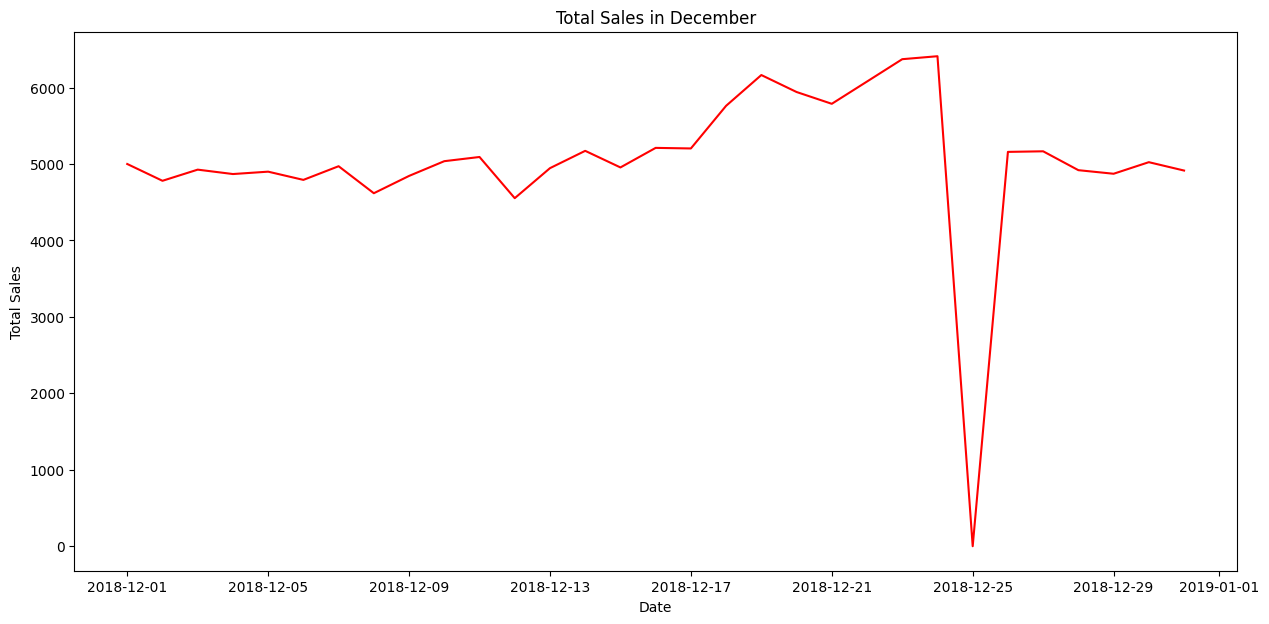

In [ ]:
plt.figure(figsize = (15,7))
plt.plot(Transaction_desember, color='red')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales in December')

<Axes: xlabel='Date', ylabel='Total Sales'>

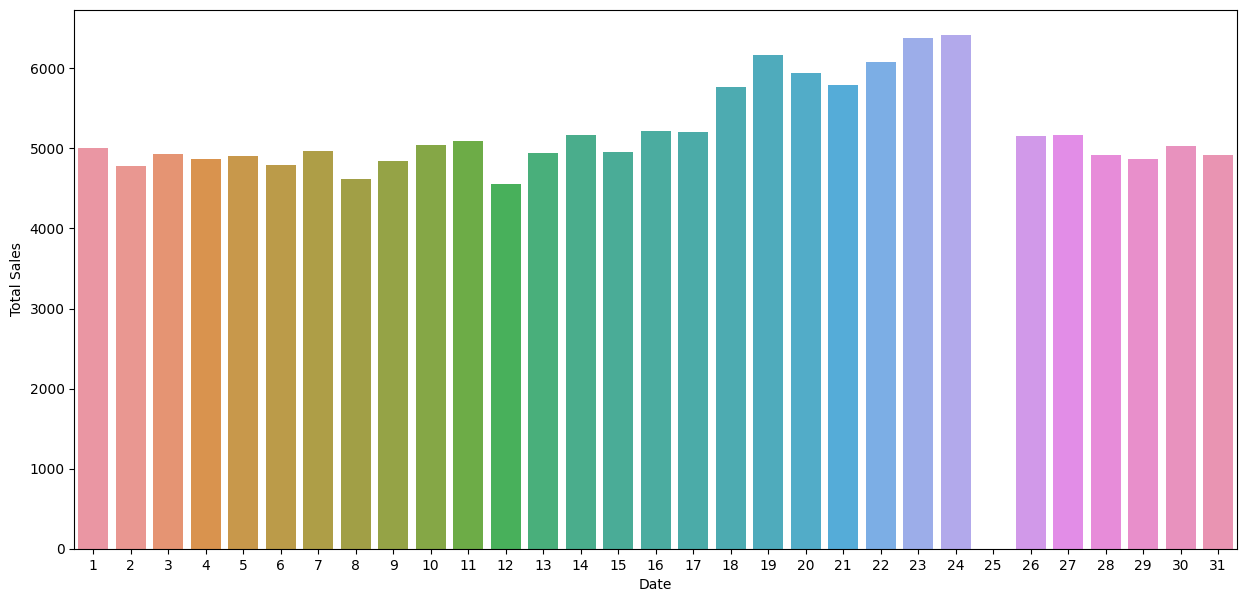

In [ ]:
Transaction_desember.reset_index(drop = True, inplace = True)
Transaction_desember['Date']= Transaction_desember.index + 1

plt.figure(figsize = (15,7))
sns.barplot(x= 'Date', y='Total Sales', data = Transaction_desember)


we can see that there is an increase in purchase in december and zero sales on 25 december which is christmas day. this make sense because shops being closed on Christmas day.

In [ ]:
# Now let's move to PACK_SIZE
TransactionData['PACK_SIZE'].isnull().sum()

0

Text(0.5, 1.0, 'Transaction by pack size')

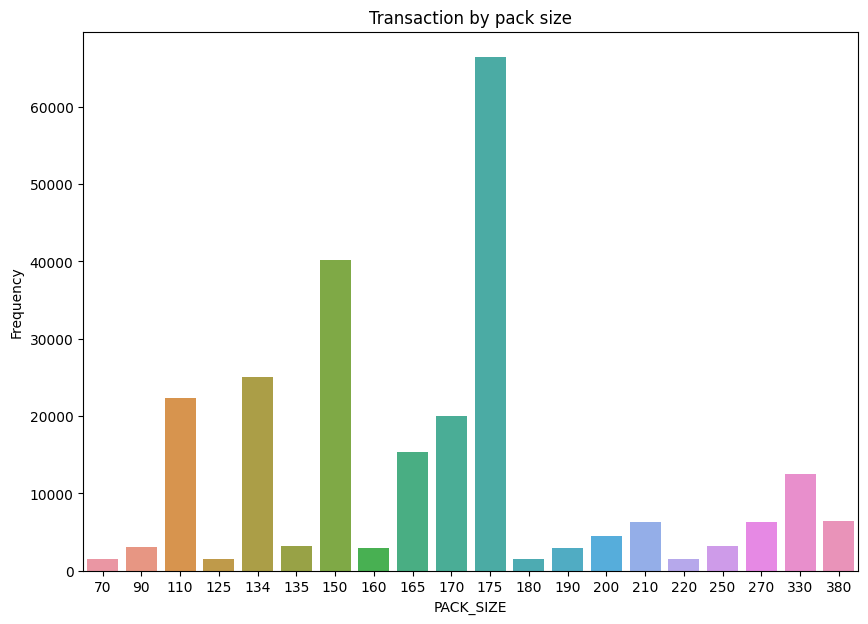

In [ ]:
# Let's plot a histogram of PACK_SIZE since we knoe it is a categorical variable and not continous even though it is numeric
d=TransactionData.groupby(['PACK_SIZE']).size().reset_index()
d.rename(columns={0:'Frequency'},inplace=True)

plt.figure(figsize =(10,7))
sns.barplot(x='PACK_SIZE', y = 'Frequency', data=d)
plt.title('Transaction by pack size')

#sns.countplot(x=TransactionData['PACK_SIZE],palette='deep').set(ylabel='Frequency')


it seems like pack size 175g has the most transaction

In [ ]:
# Next we can use first word in PROD_NAME to work out the brand name
# Extract brand name from PROD_NAME and create new column called BRAND

part = TransactionData['PROD_NAME'].str.partition()
TransactionData['BRAND'] = part[0]
TransactionData['BRAND'].head()

0    Natural
1        Ccs
2     Smiths
3     Smiths
4     Kettle
Name: BRAND, dtype: object

In [ ]:
TransactionData.groupby(['BRAND']).size().reset_index()


,BRAND,0
0,Burger,1564
1,Ccs,4551
2,Cheetos,2927
3,Cheezels,4603
4,Cobs,9693
5,Dorito,3183
6,Doritos,22041
7,French,1418
8,Grain,6272
9,Grnwves,1468


some of brand names look like they are same brand.such as snbts and sunbites

In [ ]:
## Rename Brand

TransactionData['BRAND'].replace('Ncc','Natural', inplace=True)
TransactionData['BRAND'].replace('Ww','Woolworths',inplace=True)
TransactionData['BRAND'].replace('Snbts','Sunbites',inplace=True)
TransactionData['BRAND'].replace('Smith','Smiths',inplace=True)
TransactionData['BRAND'].replace(['Red','Rrd'],'Red Rock Deli',inplace=True)
TransactionData['BRAND'].replace('Ccs','CCS',inplace=True)
TransactionData['BRAND'].replace('Infzns','Infuzions',inplace=True)
TransactionData['BRAND'].replace(['Grain','Grnwves'],'Grainwaves',inplace=True)
TransactionData['BRAND'].replace('Dorito','Doritos',inplace=True)

TransactionData.groupby(['BRAND']).size().sort_values(ascending=False).reset_index()


,BRAND,0
0,Kettle,41288
1,Smiths,30353
2,Doritos,25224
3,Pringles,25102
4,Red Rock Deli,16321
5,Infuzions,14201
6,Thins,14075
7,Woolworths,11836
8,Cobs,9693
9,Tostitos,9471


In [ ]:
# Brand which had the most sales

TransactionData.groupby('BRAND').TOT_SALES.sum().sort_values(ascending=False)

BRAND
Kettle           390239.8
Doritos          226329.9
Smiths           217492.0
Pringles         177655.5
Infuzions         99047.6
Thins             88852.5
Red Rock Deli     87607.5
Twisties          81522.1
Tostitos          79789.6
Cobs              70569.8
Tyrrells          51647.4
Grainwaves        51617.2
Natural           42318.0
Woolworths        41059.1
Cheezels          40029.9
CCS               18078.9
Cheetos           16884.5
Sunbites           9676.4
French             7929.0
Burger             6831.0
Name: TOT_SALES, dtype: float64

In [ ]:
# Count of different PROD_NAME according to packet size
TransactionData.groupby(['BRAND'])['PACK_SIZE'].value_counts()

BRAND          PACK_SIZE
Burger         220           1564
CCS            175           4551
Cheetos        190           1479
               165           1448
Cheezels       330           3149
               125           1454
Cobs           110           9693
Doritos        170          12613
               150           6376
               380           3183
               330           3052
French         175           1418
Grainwaves     210           6272
               180           1468
Infuzions      110          12694
               70            1507
Kettle         175          19022
               150          19009
               135           3257
Natural        175           7469
Pringles       134          25102
Red Rock Deli  150           8914
               165           7407
Smiths         175           7507
               170           7370
               330           6339
               150           5904
               380           3233
Sunbites       90      

Text(0.5, 1.0, 'Transactions of Different Brands')

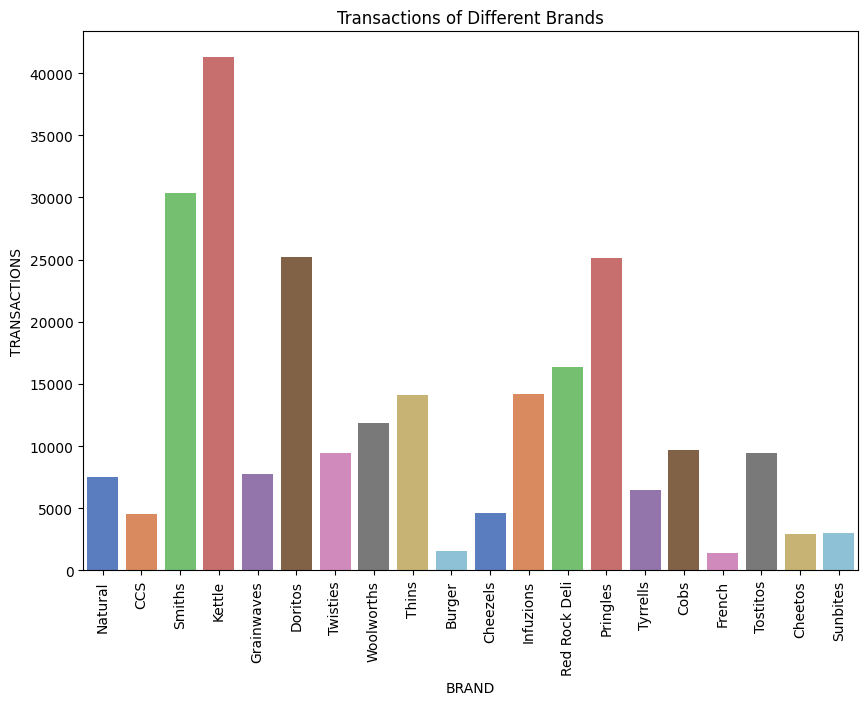

In [ ]:
#Plot data by brands
plt.figure(figsize=(10,7))
sns.countplot(x=TransactionData['BRAND'],palette='muted').set(ylabel='TRANSACTIONS')
plt.xticks(rotation=90)
plt.title("Transactions of Different Brands")


it seems like brand Kettle has the most transaction and popular one

### **Customer Data**

In [ ]:
CustomerData.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [ ]:
## check for missing vallues

CustomerData.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

<Axes: >

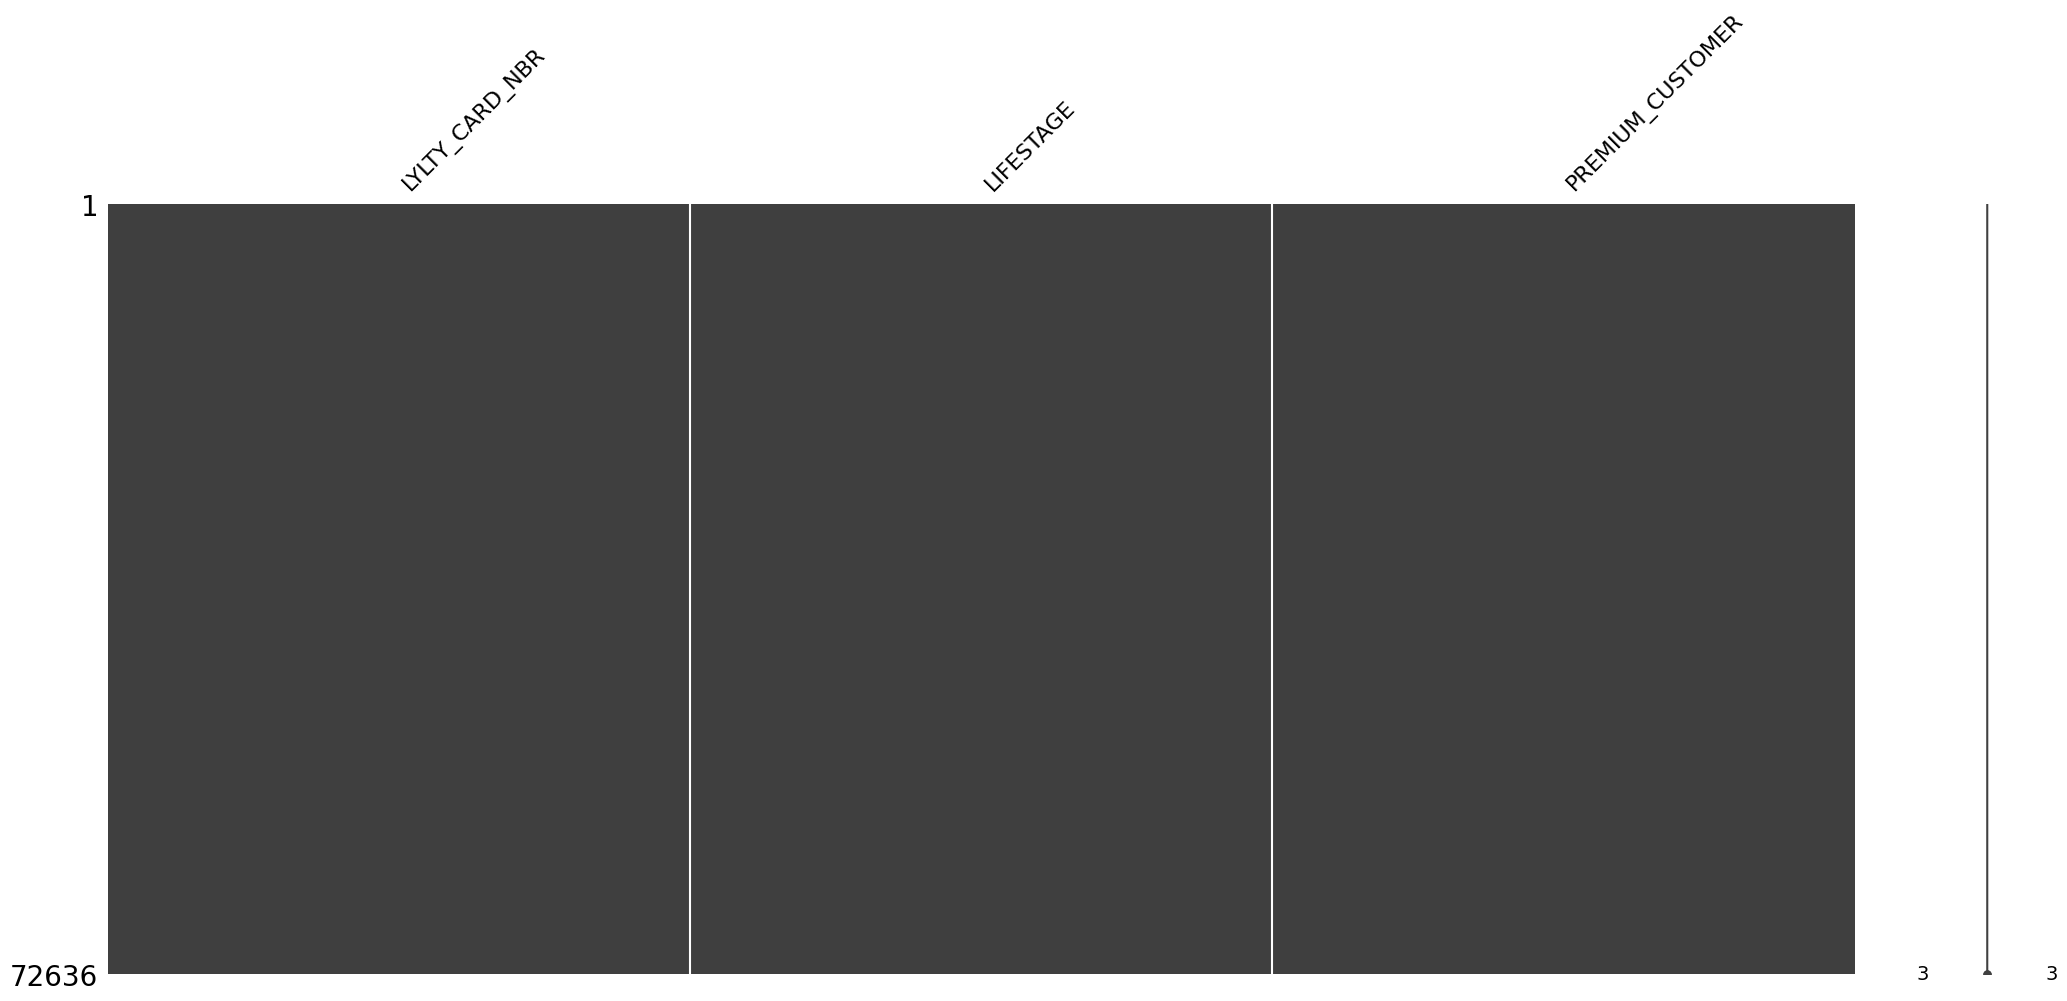

In [ ]:
missingno.matrix(CustomerData)

There is no missing value in CustomerData


In [ ]:
# what category in lifestages column
CustomerData['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [ ]:
CustomerData['LIFESTAGE'].value_counts().sort_values(ascending=False)

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9779
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

<Axes: xlabel='count', ylabel='LIFESTAGE'>

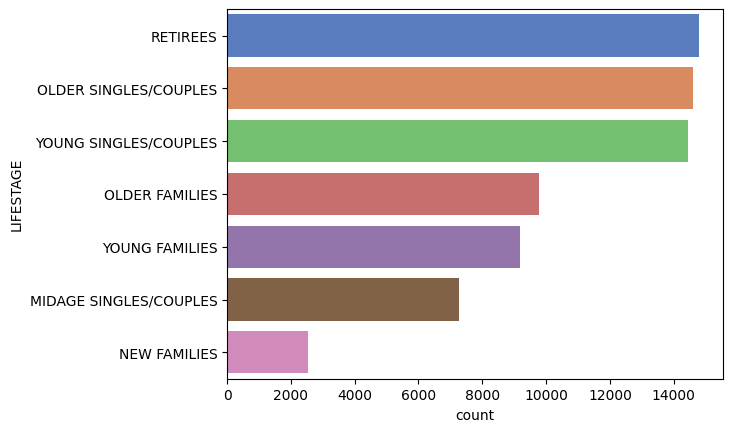

In [ ]:
sns.countplot(y=CustomerData['LIFESTAGE'], order = CustomerData['LIFESTAGE'].value_counts().index, palette='muted')

In [ ]:
# what categories in premium customer column
CustomerData['PREMIUM_CUSTOMER'].unique()

array(['Premium', 'Mainstream', 'Budget'], dtype=object)

In [ ]:
CustomerData['PREMIUM_CUSTOMER'].value_counts().sort_values(ascending=False)

Mainstream    29245
Budget        24470
Premium       18921
Name: PREMIUM_CUSTOMER, dtype: int64

<Axes: xlabel='PREMIUM_CUSTOMER', ylabel='count'>

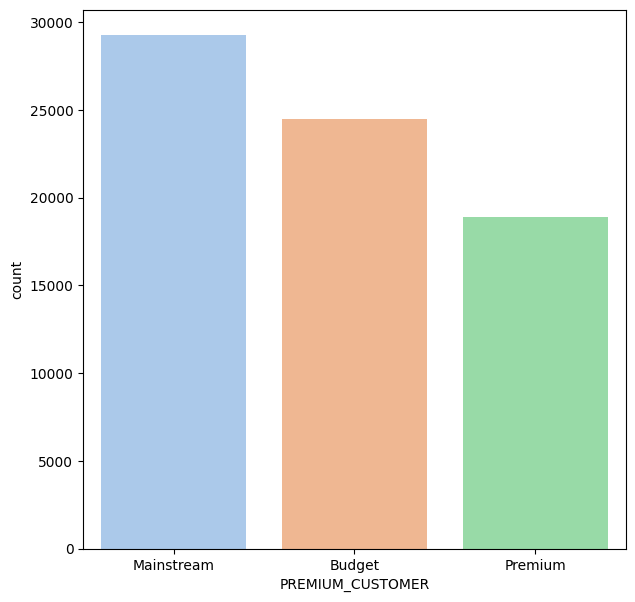

In [ ]:
plt.figure(figsize=(7,7))
plt.xlabel('Premium Customer')
plt.ylabel('Number of Customer')
sns.countplot(x=CustomerData['PREMIUM_CUSTOMER'],order=CustomerData['PREMIUM_CUSTOMER'].value_counts().index,palette='pastel')

In [ ]:
#### Merge transaction data to customer data

data= pd.merge(TransactionData, CustomerData,how='left')

In [ ]:
# check if there is null value

data.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

there are no nulls.

#### **Data analysis on Customer Segments**


*   Who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is
*   How many customers are in each segment
* How many chips are bought per customer by segment
* what's the average chip price by customer segment





In [ ]:
#### Total sales by LIFESTAGE and PREMIUM_CUSTOMER
sales = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).TOT_SALES.sum())
sales.rename(columns = {'TOT_SALES' : 'Total Sales'},inplace=True)
sales.sort_values(by = 'Total Sales', ascending = False,inplace=True)
sales

Total Sales
PREMIUM_CUSTOMER LIFESTAGE                          
Budget           OLDER FAMILIES            156863.75
Mainstream       YOUNG SINGLES/COUPLES     147582.20
                 RETIREES                  145168.95
Budget           YOUNG FAMILIES            129717.95
                 OLDER SINGLES/COUPLES     127833.60
Mainstream       OLDER SINGLES/COUPLES     124648.50
Premium          OLDER SINGLES/COUPLES     123537.55
Budget           RETIREES                  105916.30
Mainstream       OLDER FAMILIES             96413.55
Premium          RETIREES                   91296.65
Mainstream       YOUNG FAMILIES             86338.25
                 MIDAGE SINGLES/COUPLES     84734.25
Premium          YOUNG FAMILIES             78571.70
                 OLDER FAMILIES             75242.60
Budget           YOUNG SINGLES/COUPLES      57122.10
Premium          MIDAGE SINGLES/COUPLES     54443.85
                 YOUNG SINGLES/COUPLES      39052.30
Budget           MIDAGE SINGLES/COUPLES     33345.70
                 NEW FAMILIES               20607.45
Mainstream       NEW FAMILIES               15979.70
Premium          NEW FAMILIES               10760.80

In [ ]:
salesv=pd.DataFrame(data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).TOT_SALES.sum())

# pivot table salesv
table = pd.pivot_table(salesv, values='TOT_SALES', index=['LIFESTAGE'],
                       columns=['PREMIUM_CUSTOMER'], aggfunc="sum", fill_value=0)
table = table.reset_index()
table = pd.DataFrame(table)
table


PREMIUM_CUSTOMER,LIFESTAGE,Budget,Mainstream,Premium
0,MIDAGE SINGLES/COUPLES,33345.70,84734.25,54443.85
1,NEW FAMILIES,20607.45,15979.70,10760.80
2,OLDER FAMILIES,156863.75,96413.55,75242.60
3,OLDER SINGLES/COUPLES,127833.60,124648.50,123537.55
4,RETIREES,105916.30,145168.95,91296.65
5,YOUNG FAMILIES,129717.95,86338.25,78571.70
6,YOUNG SINGLES/COUPLES,57122.10,147582.20,39052.30


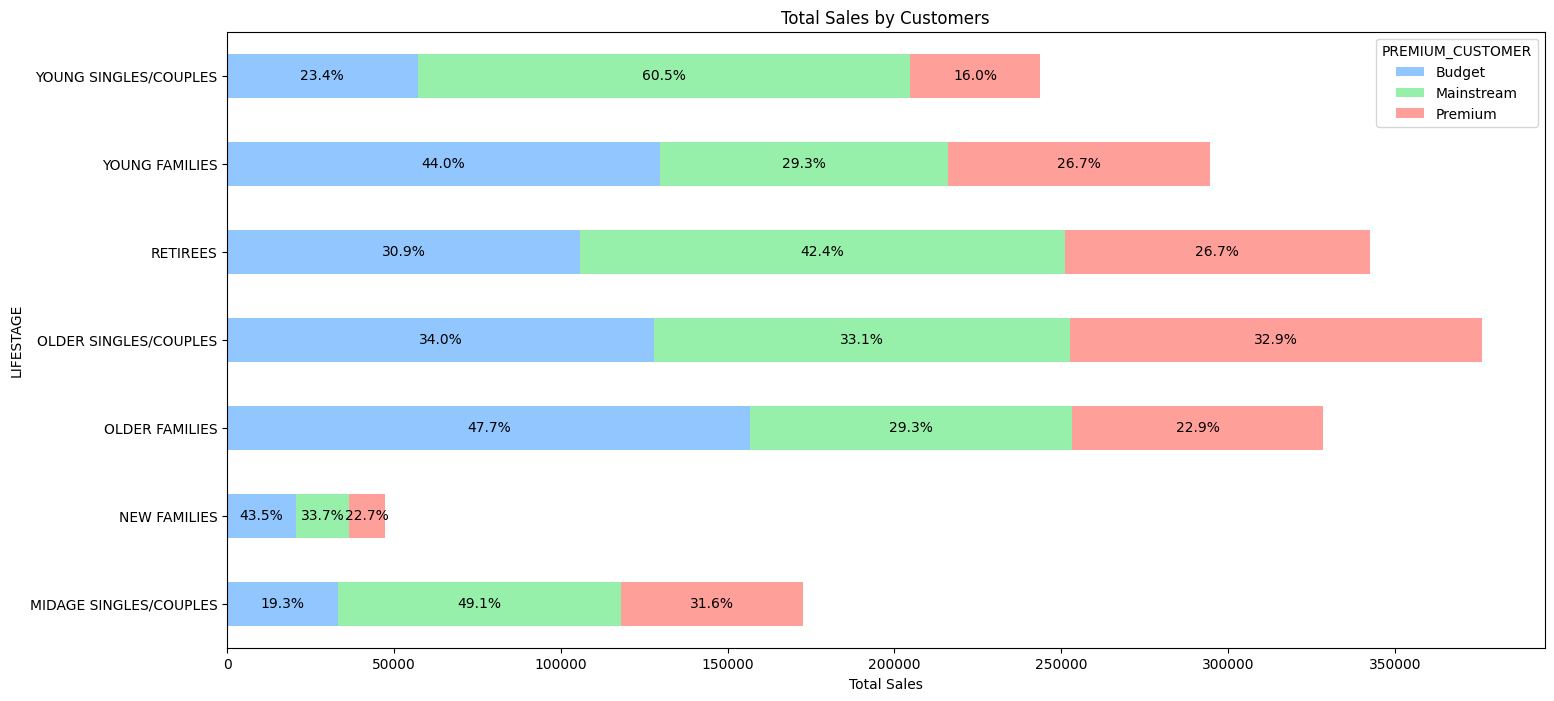

In [ ]:
# plot a Stacked Bar Chart using matplotlib
table.plot(
  x = 'LIFESTAGE',
  kind = 'barh',
  stacked = True,
  title = 'Total Sales by Customers',
  mark_right = True,figsize=(17,8)
  )
plt.xlabel('Total Sales')
plt.style.use('seaborn-v0_8-pastel')
df_total = table['Budget'] + table['Mainstream'] + table["Premium"]
df_rel = table[table.columns[1:]].div(df_total, 0) * 100

for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(table.iloc[:, 1:].cumsum(1)[n],
                                         table[n], df_rel[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%',
                 va = 'center', ha = 'center')

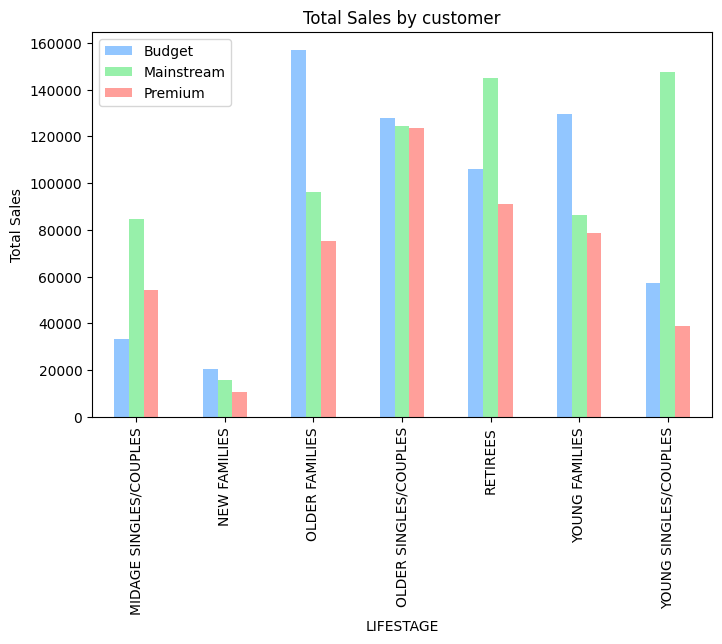

In [ ]:
salesv=pd.DataFrame(data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).TOT_SALES.sum())
#salesv=pd.DataFrame(data.groupby(['LIFESTAGE']).TOT_SALES.sum().sort_values(ascending=False))
salesv.rename(columns = {'TOT_SALES' : 'Total Sales'},inplace=True)
plt.style.use('seaborn-v0_8-pastel')
salesv.unstack().plot(kind='bar',figsize=(8,5), title = 'Total Sales by customer')
plt.ylabel('Total Sales')
plt.legend(['Budget','Mainstream','Premium'])

Sales are coming mainly from Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees. And the lowest sales by Premium - new families.

Let's see if the higher sales are due to the being more customers who buy chips

In [ ]:
### Number of customers by LIFESTAGE and PREMIUM_CUSTOMER

customer = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).LYLTY_CARD_NBR.nunique())
customer.rename(columns = {'LYLTY_CARD_NBR':'Number of Customers'},inplace=True)
customer.sort_values(by='Number of Customers',ascending=False)

Number of Customers
PREMIUM_CUSTOMER LIFESTAGE                                  
Mainstream       YOUNG SINGLES/COUPLES                  7917
                 RETIREES                               6358
                 OLDER SINGLES/COUPLES                  4858
Budget           OLDER SINGLES/COUPLES                  4849
Premium          OLDER SINGLES/COUPLES                  4682
Budget           OLDER FAMILIES                         4611
                 RETIREES                               4385
                 YOUNG FAMILIES                         3953
Premium          RETIREES                               3812
Budget           YOUNG SINGLES/COUPLES                  3647
Mainstream       MIDAGE SINGLES/COUPLES                 3298
                 OLDER FAMILIES                         2788
                 YOUNG FAMILIES                         2685
Premium          YOUNG SINGLES/COUPLES                  2480
                 YOUNG FAMILIES                         2398
                 MIDAGE SINGLES/COUPLES                 2369
                 OLDER FAMILIES                         2231
Budget           MIDAGE SINGLES/COUPLES                 1474
                 NEW FAMILIES                           1087
Mainstream       NEW FAMILIES                            830
Premium          NEW FAMILIES                            575

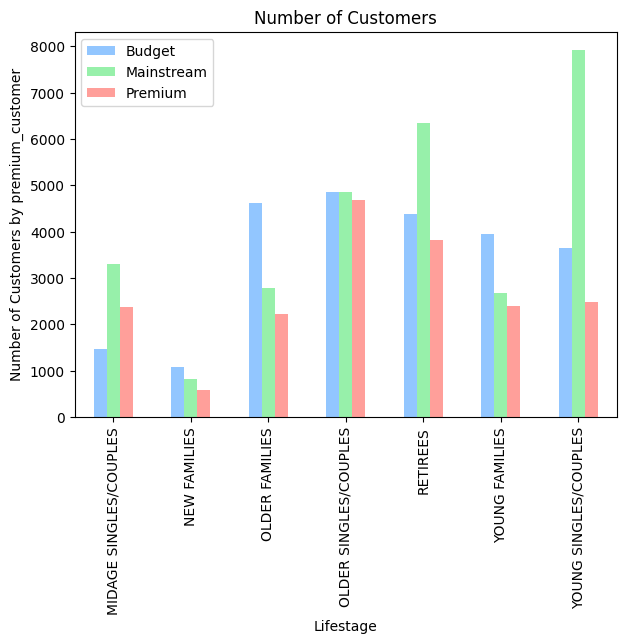

In [ ]:
customer_plot = pd.DataFrame(data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
plt.style.use('seaborn-v0_8-pastel')
customer_plot.unstack().plot(kind='bar',figsize=(7,5),title='Number of Customers')
plt.xlabel('Lifestage')
plt.ylabel('Number of Customers by premium_customer')
plt.legend(['Budget','Mainstream','Premium'])

In [ ]:
# proportions plot
custv = pd.DataFrame(data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())

# pivot table custv
table = pd.pivot_table(custv, values='LYLTY_CARD_NBR', index=['LIFESTAGE'],
                       columns=['PREMIUM_CUSTOMER'], aggfunc="sum", fill_value=0)
table = table.reset_index()
table = pd.DataFrame(table)
table

PREMIUM_CUSTOMER,LIFESTAGE,Budget,Mainstream,Premium
0,MIDAGE SINGLES/COUPLES,1474,3298,2369
1,NEW FAMILIES,1087,830,575
2,OLDER FAMILIES,4611,2788,2231
3,OLDER SINGLES/COUPLES,4849,4858,4682
4,RETIREES,4385,6358,3812
5,YOUNG FAMILIES,3953,2685,2398
6,YOUNG SINGLES/COUPLES,3647,7917,2480


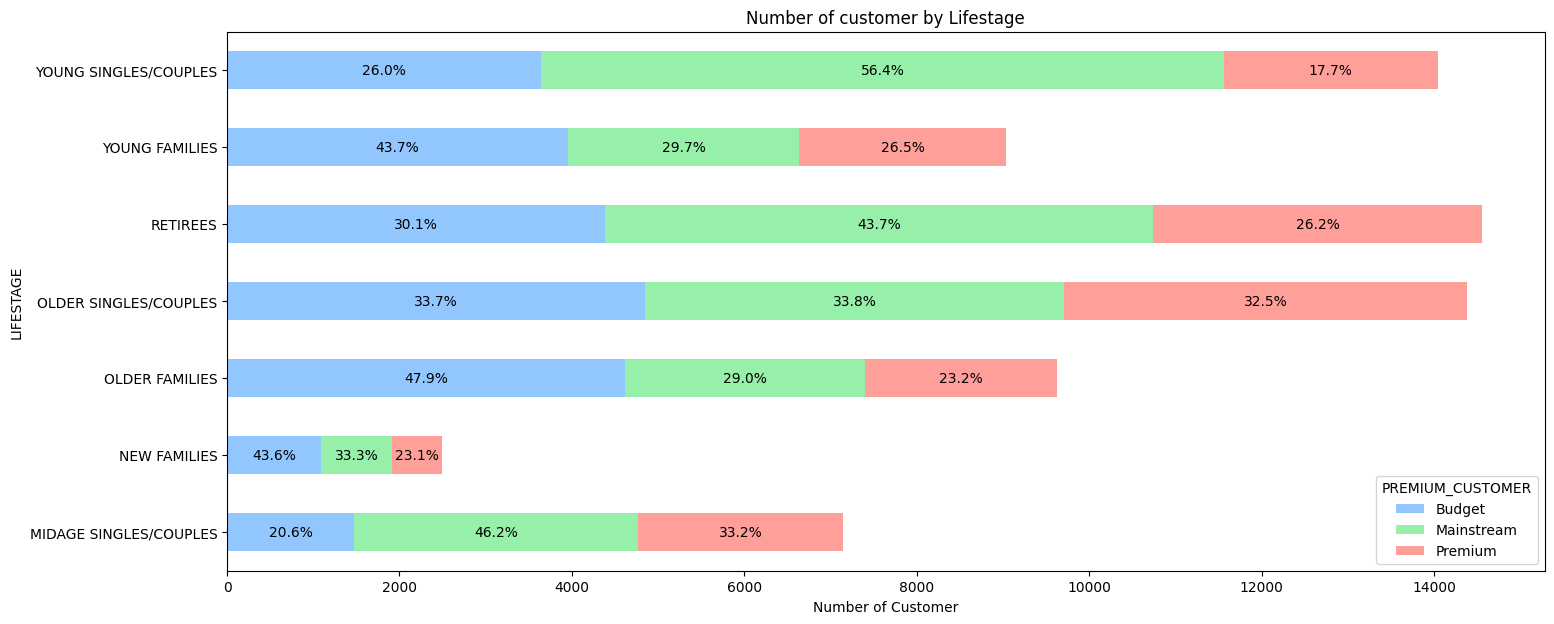

In [ ]:
# plot a Stacked Bar Chart using matplotlib
table.plot(
  x = 'LIFESTAGE',
  kind = 'barh',
  stacked = True,
  title = 'Number of customer by Lifestage',
  mark_right = True,figsize=(17, 7)
  )
plt.xlabel('Number of Customer')

df_total = table['Budget'] + table['Mainstream'] + table["Premium"]
df_rel = table[table.columns[1:]].div(df_total, 0) * 100

for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(table.iloc[:, 1:].cumsum(1)[n],
                                         table[n], df_rel[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%',
                 va = 'center', ha = 'center')

there looks Maintream- young singles/couples who most buy chips. it seems like number of customers not major driver for Budget - Older families segment to being more sales.

Higher  sales may also be  driven by more units chips being bought per custome. Let's see

In [ ]:
# Average units per customer by PREMIUM_CUSTOMER and LIFESTAGE

avg_units = data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum() / data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique()
avg_units = pd.DataFrame(avg_units)
avg_units.rename(columns = {0:'Average Unit per Customer'},inplace=True)
avg_units.sort_values(by = 'Average Unit per Customer', ascending = False).head()

,,Average Unit per Customer
PREMIUM_CUSTOMER,LIFESTAGE,
Mainstream,OLDER FAMILIES,9.255380
Budget,OLDER FAMILIES,9.076773
Premium,OLDER FAMILIES,9.071717
Budget,YOUNG FAMILIES,8.722995
Premium,YOUNG FAMILIES,8.716013


Text(0, 0.5, 'Avg units per Transactions')

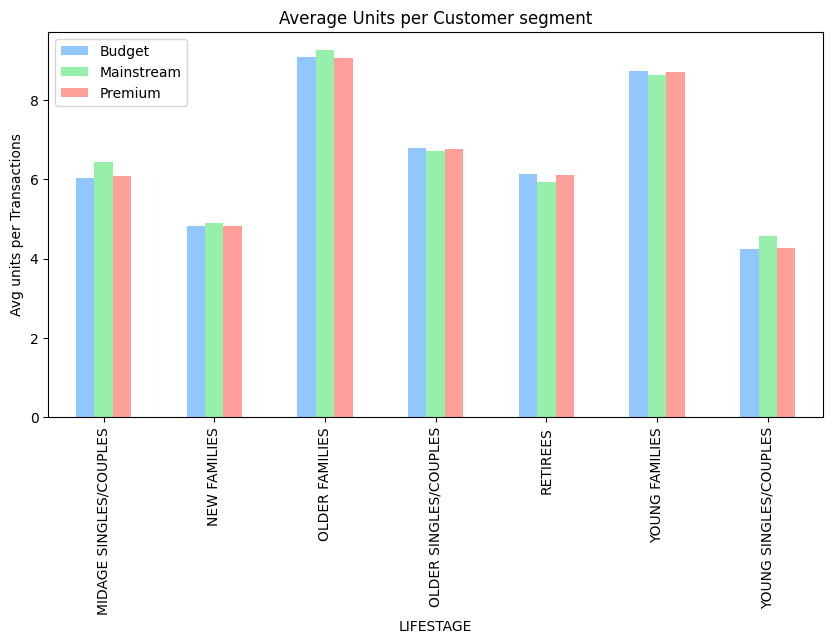

In [ ]:
avg_plot = data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).PROD_QTY.sum() / data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique()
avg_plot = pd.DataFrame(avg_plot)
plt.style.use('seaborn-v0_8-pastel')
avg_plot.unstack().plot(kind='bar',figsize=(10,5),title='Average Units per Customer segment')
plt.legend(['Budget','Mainstream','Premium'])
plt.ylabel('Avg units per Transactions')


it seems older families and young families in general buy more chips per customer.

Next, Let's also investigate the average price per units chips bought for each customer segment.

In [ ]:
## Average price per unit by  LIFESTAGE and PREMIUM_CUSTOMER

avg_price = data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).TOT_SALES.sum()/data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).PROD_QTY.sum()
avg_price = pd.DataFrame(avg_price)
avg_price.rename(columns={0:'Average price per unit'},inplace=True)
avg_price.sort_values(by='Average price per unit',ascending=False).head(10)

Average price per unit
PREMIUM_CUSTOMER LIFESTAGE                                     
Mainstream       YOUNG SINGLES/COUPLES                 4.074043
                 MIDAGE SINGLES/COUPLES                3.994449
                 NEW FAMILIES                          3.935887
Budget           RETIREES                              3.932731
                 NEW FAMILIES                          3.931969
Premium          RETIREES                              3.924037
                 OLDER SINGLES/COUPLES                 3.897698
Budget           OLDER SINGLES/COUPLES                 3.887529
Premium          NEW FAMILIES                          3.886168
Mainstream       RETIREES                              3.852986

Text(0, 0.5, 'Avg price per unit')

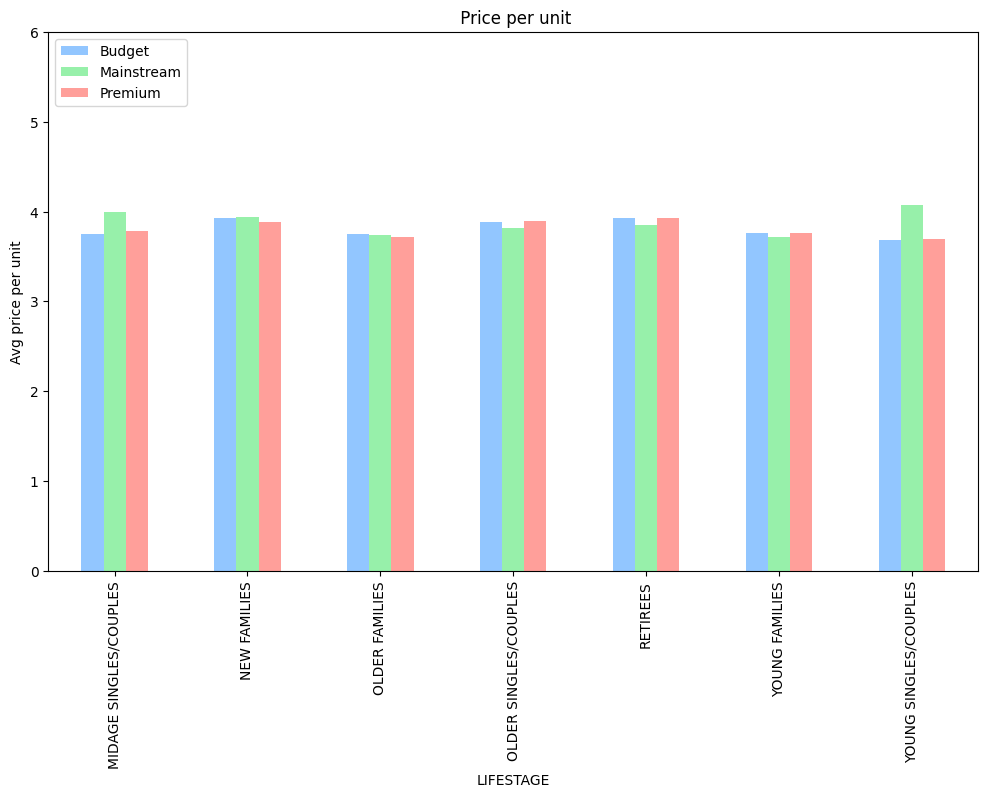

In [ ]:
avg_price_plot = data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).TOT_SALES.sum()/data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).PROD_QTY.sum()
avg_price_plot = pd.DataFrame(avg_price_plot)
plt.style.use('seaborn-v0_8-pastel')
avg_price_plot.unstack().plot(kind='bar',figsize=(12,7),title=' Price per unit',ylim=(0,6))
plt.legend(['Budget','Mainstream','Premium'],loc= 2)
plt.ylabel('Avg price per unit')

Mainstream young and midage singles/couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own comsumpyion. This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counteparts.


The difference in average price per unit isn’t large, Let's check if this difference is statistically different.

In [ ]:
# Perform an independent t-test between mainstream vs non-mainstream midage and young singles/couples to test this difference

PricePerUnit = data
PricePerUnit['PRICE'] = PricePerUnit['TOT_SALES']/PricePerUnit['PROD_QTY']
PricePerUnit.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium,3.00
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget,2.10
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget,1.45
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget,3.00
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chpshny Jlpno Chili,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget,4.60


In [ ]:
# Let's group our data into mainstream and non-mainstream

mainstream= PricePerUnit.loc[(PricePerUnit['PREMIUM_CUSTOMER'] == 'Mainstream') & ((PricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (PricePerUnit['LIFESTAGE'] =='MIDAGE SINGLES/COUPLES')), 'PRICE']
nonmainstream= PricePerUnit.loc[(PricePerUnit['PREMIUM_CUSTOMER'] != 'Mainstream') & ((PricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (PricePerUnit['LIFESTAGE'] =='MIDAGE SINGLES/COUPLES')), 'PRICE']


Text(0.5, 0, 'Price per Unit')

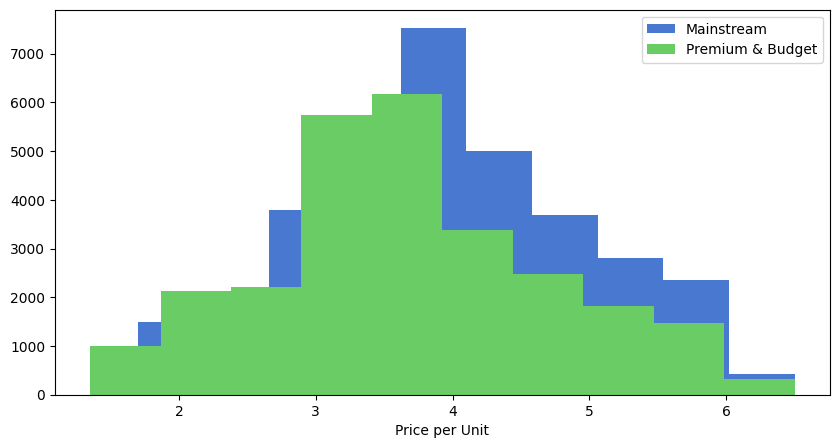

In [ ]:
# compare histoframs of mainstream and non-mainstream customers
plt.style.use('seaborn-v0_8-muted')
plt.figure(figsize = (10, 5))
plt.hist(mainstream, label = 'Mainstream')
plt.hist(nonmainstream, label = 'Premium & Budget')
plt.legend()
plt.xlabel('Price per Unit')

In [ ]:
# mainstream avg price per unit
print("Mainstream average price per unit: ${:.2f}".format(np.mean(mainstream)))
print("Non-Mainstream average price pre unit: ${:.2f}".format(np.mean(nonmainstream)))
if np.mean(mainstream) > np.mean(nonmainstream):
   print("Mainstream customer have higher average price per unit")
else:
   print("Non-Mainstream customer have higher average price per unit")


Mainstream average price per unit: $4.04
Non-Mainstream average price pre unit: $3.71
Mainstream customer have higher average price per unit


In [ ]:
# t-test

ttest_ind(mainstream, nonmainstream,equal_var=True)


TtestResult(statistic=37.83196107667815, pvalue=2.235645611549355e-309, df=57365.0)

average price per unit for mainstream, young and mid-age singles and
couples are significantly higher than that of budget or premium, young and midage singles and couples.


#### **Deep dive into specific  customer segments for insight**

we have found quite a few interesting insughts that we can dive deeper into.

we might want to target customer that contribute the most to sales to retain them or further increase sales.Let's examine mainstream young singles/couples against the rest of the cutomer segments to see if they prefer any particular brand of chips.

In [ ]:
## Deep dive into Mainstream, young singles/couples

segment1 =data.loc[(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream'), :]
others = data.loc[(data['LIFESTAGE'] != 'YOUNG SINGLES/COUPLES' ) & (data['PREMIUM_CUSTOMER'] != 'Mainstream'), :]
segment1.head()


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
221345,2018-08-16,1,1020,26,19,Smiths Crinkle Cut Snag Sauce,1,2.6,150,Smiths,YOUNG SINGLES/COUPLES,Mainstream,2.6
221346,2018-08-17,1,1163,188,46,Kettle Original,1,5.4,175,Kettle,YOUNG SINGLES/COUPLES,Mainstream,5.4
221347,2018-08-14,1,1291,333,27,Ww Supreme Cheese Corn Chips,1,1.9,200,Woolworths,YOUNG SINGLES/COUPLES,Mainstream,1.9
221348,2019-05-15,3,3031,1227,14,Smiths Crnkle Chip Orgnl Big Bag,1,5.9,380,Smiths,YOUNG SINGLES/COUPLES,Mainstream,5.9
221349,2019-05-18,3,3118,1574,62,Pringles Mystery Flavour,1,3.7,134,Pringles,YOUNG SINGLES/COUPLES,Mainstream,3.7


#### **Affinity to Brand**

In [ ]:
## Brand affinity

quantity_target = segment1['PROD_QTY'].sum()
quantity_nontarget = others['PROD_QTY'].sum()

targetBrand = segment1.loc[:, ['BRAND','PROD_QTY']]
nontargetBrand = others.loc[:, ['BRAND','PROD_QTY']]

targetBrand['Target Brand Affinity'] = targetBrand['PROD_QTY'] / quantity_target
nontargetBrand['Non-target Brand Affinity'] = nontargetBrand['PROD_QTY'] / quantity_nontarget

targetBrand = pd.DataFrame(targetBrand.groupby('BRAND')['Target Brand Affinity'].sum())
nontargetBrand = pd.DataFrame(nontargetBrand.groupby('BRAND')['Non-target Brand Affinity'].sum())

In [ ]:
# Merge two dataframe

Brand_proportions = pd.merge(targetBrand, nontargetBrand, left_index=True, right_index=True)
Brand_proportions['Affinity to Brand'] = Brand_proportions['Target Brand Affinity'] / Brand_proportions['Non-target Brand Affinity']
Brand_proportions.sort_values(by='Affinity to Brand', ascending = False).reset_index()

,BRAND,Target Brand Affinity,Non-target Brand Affinity,Affinity to Brand
0,Tyrrells,0.031553,0.025715,1.227025
1,Twisties,0.046184,0.037933,1.217506
2,Doritos,0.122761,0.101171,1.213397
3,Kettle,0.197985,0.166560,1.188667
4,Tostitos,0.045411,0.038350,1.184100
5,Pringles,0.119420,0.101110,1.181090
6,Cobs,0.044638,0.038449,1.160959
7,Infuzions,0.064679,0.057410,1.126622
8,Thins,0.060373,0.057159,1.056217
9,Grainwaves,0.032712,0.031069,1.052895


We can see that:

*   Mainstream- young singles/couples are 23% more likely to purchase Tyrrells chips compared to the rest of the population
*   Mainstream young singles/couples are 56% less likely to purchase Burger compared to the rest of the population



#### **Affinity to pack size**

In [ ]:
# Target : Mainstream young singles couples
TargetSize = segment1.loc[:, ['PACK_SIZE', 'PROD_QTY']]
TargetSum = TargetSize['PROD_QTY'].sum()
TargetSize['Target Pack Affinity'] = TargetSize['PROD_QTY']/TargetSum
TargetSize = pd.DataFrame(TargetSize.groupby('PACK_SIZE')['Target Pack Affinity'].sum())

# Non-Target
NonTargetSize = others.loc[:, ['PACK_SIZE', 'PROD_QTY']]
NonTargetSum = NonTargetSize['PROD_QTY'].sum()
NonTargetSize['Non-Target Pack Affinity'] = NonTargetSize['PROD_QTY']/NonTargetSum
NonTargetSize = pd.DataFrame(NonTargetSize.groupby('PACK_SIZE')['Non-Target Pack Affinity'].sum())

# Merge two Data frame
pack_proportions = pd.merge(TargetSize, NonTargetSize,left_index = True, right_index = True )
pack_proportions['Affinity to Pack'] = pack_proportions['Target Pack Affinity']/ pack_proportions['Non-Target Pack Affinity']
pack_proportions.sort_values(by='Affinity to Pack', ascending=False)

,Target Pack Affinity,Non-Target Pack Affinity,Affinity to Pack
PACK_SIZE,,,
270,0.031829,0.025070,1.269608
380,0.032160,0.025711,1.250827
330,0.061284,0.050974,1.202243
110,0.106280,0.089575,1.186492
134,0.119420,0.101110,1.181090
210,0.029124,0.024891,1.170020
135,0.014769,0.012931,1.142086
250,0.014355,0.012863,1.115959
170,0.080773,0.080347,1.005300


it seems like mainstream- young singles and couples are 27% more likely to purchase a 270g pack size compared to other pack sizes.

In [ ]:
## which brand offer 270g pack size

(pd.DataFrame(data.loc[data['PACK_SIZE']==270,:]))['PROD_NAME'].unique()

array(['Twisties Cheese      ', 'Twisties Chicken '], dtype=object)

Twisties are the only brand offering 270g pack size and so this may instead be reflecting a higher likelihood of purchasing Twisties.

#### **Conclusion**



1.  Generally, Sales increase significantly in December before Cristmas day on 25th December

2. Top 3 highest sales:
    * Budget - Older Familes
    * Mainstream - Young Singles/Couples
    * Mainstream - Retirees

3.  We found that high spend for (Mainstream - Young Singles/Couples) and (Mainstream - Retirees) are mainly due to the fact that there are more customers in these segment compared to others buyers.

4. Despite Older families not having highest customers, but they have the highest average units of purchase for each segment, which contributes to their high total sales.

5. Mainstream - Young singles/Couples are also more likely to pay more per packet of chips. this is indicate impulsive buying behaviour.

6. Mainstream - Young singles/couples are more likely to purchase Tyrells followed by twisties and  27% more likely to purchase 270g pack size which is only offer by brand twisties.

7. in general for all segments, brand chips kettle has the most frequently purchased brand and burger is the lowest.

8. most frequent chips size purchased is 175g pack size.


